
# Portfolio Optimization & Performance (MPT) — Example Notebook

This notebook demonstrates how to:
- Build an **efficient frontier**
- Construct **equal-weight**, **minimum-variance**, and **max-Sharpe** portfolios
- Evaluate using **Sharpe**, **Beta**, **Treynor**, and **Jensen’s Alpha**

It uses **synthetic weekly price data** so the workflow runs immediately. You can later replace with **Bloomberg** data.

## How to use with your Bloomberg data
1. Export weekly (or monthly) **Adjusted Close** prices for **6–10 tickers** plus your **benchmark** (e.g., S&P 500 or FTSE 100).
2. Assemble a CSV with columns: `Date, <TICKER_1>, ..., <TICKER_N>, Benchmark` where `Date` is YYYY-MM-DD.
3. In **Section 4**, you can **skip** the synthetic generator and instead **load your CSV**, then proceed with the rest of the notebook.
4. Set `rf_annual` to your preferred annualised risk-free rate (e.g., 3M T-bill).

> Tip: Use **weekly** frequency for stability (about 52 periods/year). Monthly also works—just change `periods_per_year` accordingly.


In [1]:

# === Imports ===
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime

# Make plots a bit larger
plt.rcParams['figure.figsize'] = (8, 5)


In [2]:
import sys
print(sys.executable)


/opt/anaconda3/bin/python


In [3]:

# === Helper Functions ===

def annualize_return(mean_periodic, periods_per_year):
    return mean_periodic * periods_per_year

def annualize_vol(vol_periodic, periods_per_year):
    return vol_periodic * np.sqrt(periods_per_year)

def portfolio_stats(weights, mu_vec, cov_mat, rf_annual, periods_per_year):
    w = np.array(weights)
    mu_p = float(np.dot(w, mu_vec))  # periodic expected return
    vol_p = float(np.sqrt(np.dot(w, cov_mat).dot(w)))
    mu_ann = annualize_return(mu_p, periods_per_year)
    vol_ann = annualize_vol(vol_p, periods_per_year)
    sharpe = (mu_ann - rf_annual) / vol_ann if vol_ann > 0 else np.nan
    return mu_ann, vol_ann, sharpe

def compute_beta_and_alpha(port_rets, bench_rets, rf_periodic, periods_per_year):
    # Beta = Cov(Rp, Rm) / Var(Rm)
    # Jensen's alpha (annualised): alpha_ann = [ (mean(Rp) - rf) - beta*(mean(Rm) - rf) ] * periods_per_year
    var_m = np.var(bench_rets, ddof=1)
    cov_pm = np.cov(port_rets, bench_rets, ddof=1)[0,1]
    beta = cov_pm / var_m if var_m > 0 else np.nan
    mean_p = np.mean(port_rets)
    mean_m = np.mean(bench_rets)
    alpha_periodic = (mean_p - rf_periodic) - beta * (mean_m - rf_periodic)
    alpha_annual = alpha_periodic * periods_per_year
    return beta, alpha_annual

def solve_min_variance(cov_mat, bounds):
    n = cov_mat.shape[0]
    init = np.repeat(1.0/n, n)
    cons = ({'type':'eq','fun': lambda w: np.sum(w) - 1},)
    res = minimize(lambda w: np.dot(w, cov_mat).dot(w),
                   init, method='SLSQP', bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError("Min-variance optimization failed")
    return res.x

def solve_max_sharpe(mu_vec, cov_mat, rf_annual, periods_per_year, bounds):
    n = len(mu_vec)
    init = np.repeat(1.0/n, n)
    cons = ({'type':'eq','fun': lambda w: np.sum(w) - 1},)
    def neg_sharpe(w):
        mu_ann, vol_ann, sharpe = portfolio_stats(w, mu_vec, cov_mat, rf_annual, periods_per_year)
        return -sharpe
    res = minimize(neg_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError("Max-Sharpe optimization failed")
    return res.x

def solve_efficient_frontier(mu_vec, cov_mat, target_returns, bounds):
    n = len(mu_vec)
    init = np.repeat(1.0/n, n)
    cons_base = ({'type':'eq','fun': lambda w: np.sum(w) - 1},)
    sols, vols = [], []
    for tr in target_returns:
        def port_var(w): return np.dot(w, cov_mat).dot(w)
        cons = cons_base + ({'type':'eq','fun': lambda w, tr=tr: np.dot(w, mu_vec) - tr},)
        res = minimize(port_var, init, method='SLSQP', bounds=bounds, constraints=cons)
        if res.success:
            w = res.x
            sols.append(w)
            vols.append(np.sqrt(np.dot(w, cov_mat).dot(w)))
        else:
            sols.append(np.full(n, np.nan))
            vols.append(np.nan)
    return np.array(sols), np.array(vols)

def portfolio_periodic_returns(weights, R):
    return (R.values @ np.array(weights)).astype(float)



## 1) Data Setup

Run the next cell to **generate synthetic weekly prices** (works out of the box).  
**OR** comment that block and **uncomment** the CSV loader to use your **Bloomberg** prices.


In [4]:

# === Parameters ===
periods_per_year = 52    # use 12 for monthly data
rf_annual = 0.03         # annualised risk-free rate (e.g., 3M T-bill)
np.random.seed(42)

# === Synthetic data generator (default) ===
tickers = ["AAPL", "MSFT", "JPM", "XOM", "JNJ", "KO", "NVDA", "AMZN"]
years = 4
n = len(tickers)

dates = pd.date_range(end=pd.Timestamp.today().normalize(), periods=years*periods_per_year, freq="W-FRI")

# Create a random covariance & simulate weekly returns
k = 3  # factors
loadings = np.random.normal(0, 0.5, size=(n, k))
factor_cov = np.diag(np.random.uniform(0.5, 1.5, size=k))
idiosyncratic = np.diag(np.random.uniform(0.05, 0.15, size=n))
cov_weekly = loadings @ factor_cov @ loadings.T + idiosyncratic

mu_weekly = np.random.uniform(0.0008, 0.004, size=n)
L = np.linalg.cholesky(cov_weekly)
Z = np.random.normal(size=(len(dates), n))
eps = Z @ L.T
rets = mu_weekly + eps  # small arithmetic weekly returns

# Convert to cumulative prices starting at 100
prices = 100 * (1 + rets).cumprod(axis=0)
prices_df = pd.DataFrame(prices, index=dates, columns=tickers)

# Synthetic benchmark, correlated with cross-section average
bench_mu = 0.0025
bench_noise = np.random.normal(bench_mu, 0.05, size=len(dates))
bench_rets = 0.6 * rets.mean(axis=1) + 0.4 * bench_noise
benchmark_prices = 100 * (1 + pd.Series(bench_rets, index=dates)).cumprod()

# === OPTIONAL: Load your Bloomberg CSV instead ===
# Expected columns: Date, <TICKER_1>, ..., <TICKER_N>, Benchmark
# csv_path = "your_prices.csv"
# df = pd.read_csv(csv_path, parse_dates=["Date"])
# df = df.set_index("Date").sort_index()
# prices_df = df.drop(columns=["Benchmark"])
# benchmark_prices = df["Benchmark"]
# tickers = list(prices_df.columns)
# n = len(tickers)

prices_df.head()


,AAPL,MSFT,JPM,XOM,JNJ,KO,NVDA,AMZN
2021-11-19,240.022571,285.897512,267.092686,179.277904,-20.716179,-8.120356,81.733515,-55.378829
2021-11-26,77.905221,-38.083481,-169.550301,141.659736,-42.330515,-16.351010,198.479747,-90.254467
2021-12-03,69.956149,-17.089041,67.800665,186.009909,-64.224004,-24.935044,496.398879,-38.753196
2021-12-10,99.496432,-25.826822,54.951865,205.085252,-120.112911,-41.186987,1264.717229,-18.187054
2021-12-17,268.551980,-36.706191,46.559972,134.616483,262.452109,-64.438895,4680.285676,34.023272


## 2) Compute Returns & Inputs for MPT

In [5]:

# Convert prices to periodic returns
R = prices_df.pct_change().dropna()
R_bench = pd.Series(benchmark_prices).pct_change().dropna()

# Inputs
mu_vec = R.mean().values       # periodic mean vector
cov_mat = R.cov().values       # periodic covariance matrix
rf_periodic = rf_annual / periods_per_year

R.tail()


,AAPL,MSFT,JPM,XOM,JNJ,KO,NVDA,AMZN
2025-10-10,-0.403046,0.192569,0.427157,0.336716,2.239930,0.159179,-0.820961,0.357857
2025-10-17,-0.081019,0.957073,0.898515,-0.520809,-0.442225,-0.200885,-0.315987,-0.623393
2025-10-24,-0.282237,-0.506794,-0.826090,-1.011208,0.086572,0.750404,0.139159,0.708701
2025-10-31,-0.049632,0.915421,0.927332,0.488849,1.086449,-0.593849,-0.589944,-0.103615
2025-11-07,-0.200107,0.272154,0.008271,0.542865,2.085467,0.630743,-0.831726,1.079296


## 3) Portfolio Optimization

In [6]:

bounds = tuple((0.0, 1.0) for _ in range(n))  # long-only

# Equal-weight (baseline)
w_equal = np.repeat(1.0/n, n)

# Min-variance
w_minvar = solve_min_variance(cov_mat, bounds)

# Max-Sharpe
w_maxsharpe = solve_max_sharpe(mu_vec, cov_mat, rf_annual, periods_per_year, bounds)

# Efficient frontier along target periodic returns
target_periodic = np.linspace(mu_vec.min()*0.8, mu_vec.max()*1.2, 30)
ef_weights, ef_vols = solve_efficient_frontier(mu_vec, cov_mat, target_periodic, bounds)
ef_returns_ann = annualize_return(target_periodic, periods_per_year)
ef_vols_ann = annualize_vol(ef_vols, periods_per_year)

w_equal, w_minvar, w_maxsharpe


(array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]),
 array([2.36556040e-01, 2.27682456e-18, 1.61554506e-01, 6.41609046e-03,
        2.00577402e-18, 6.51783533e-02, 2.05659927e-01, 3.24635084e-01]),
 array([0.00000000e+00, 9.33752618e-02, 5.09786434e-02, 1.14137682e-16,
        1.49802389e-02, 0.00000000e+00, 4.31858059e-01, 4.08807797e-01]))

## 4) Performance Metrics

In [7]:

# Equal-weight
mu_eq_ann, vol_eq_ann, sharpe_eq = portfolio_stats(w_equal, mu_vec, cov_mat, rf_annual, periods_per_year)
rp_eq = portfolio_periodic_returns(w_equal, R)
beta_eq, alpha_eq_ann = compute_beta_and_alpha(rp_eq, R_bench.values, rf_periodic, periods_per_year)
treynor_eq = (mu_eq_ann - rf_annual) / beta_eq if beta_eq and beta_eq != 0 else np.nan

# Min-variance
mu_mv_ann, vol_mv_ann, sharpe_mv = portfolio_stats(w_minvar, mu_vec, cov_mat, rf_annual, periods_per_year)
rp_mv = portfolio_periodic_returns(w_minvar, R)
beta_mv, alpha_mv_ann = compute_beta_and_alpha(rp_mv, R_bench.values, rf_periodic, periods_per_year)
treynor_mv = (mu_mv_ann - rf_annual) / beta_mv if beta_mv and beta_mv != 0 else np.nan

# Max-Sharpe
mu_ms_ann, vol_ms_ann, sharpe_ms = portfolio_stats(w_maxsharpe, mu_vec, cov_mat, rf_annual, periods_per_year)
rp_ms = portfolio_periodic_returns(w_maxsharpe, R)
beta_ms, alpha_ms_ann = compute_beta_and_alpha(rp_ms, R_bench.values, rf_periodic, periods_per_year)
treynor_ms = (mu_ms_ann - rf_annual) / beta_ms if beta_ms and beta_ms != 0 else np.nan

metrics_table = pd.DataFrame([
    {"Portfolio":"Equal-Weight", "Exp Return (ann)": mu_eq_ann, "Vol (ann)": vol_eq_ann, "Sharpe": sharpe_eq, "Beta": beta_eq, "Treynor": treynor_eq, "Jensen Alpha (ann)": alpha_eq_ann},
    {"Portfolio":"Min-Variance", "Exp Return (ann)": mu_mv_ann, "Vol (ann)": vol_mv_ann, "Sharpe": sharpe_mv, "Beta": beta_mv, "Treynor": treynor_mv, "Jensen Alpha (ann)": alpha_mv_ann},
    {"Portfolio":"Max-Sharpe", "Exp Return (ann)": mu_ms_ann, "Vol (ann)": vol_ms_ann, "Sharpe": sharpe_ms, "Beta": beta_ms, "Treynor": treynor_ms, "Jensen Alpha (ann)": alpha_ms_ann},
])
metrics_table.round(4)


,Portfolio,Exp Return (ann),Vol (ann),Sharpe,Beta,Treynor,Jensen Alpha (ann)
0,Equal-Weight,1.6573,2.2212,0.7326,1.6543,0.9837,0.0524
1,Min-Variance,1.4343,1.2740,1.1023,0.6887,2.0389,0.7486
2,Max-Sharpe,5.0332,2.1382,2.3399,0.6264,7.9877,4.4068


## 5) Portfolio Weights

In [8]:

weights_table = pd.DataFrame({
    "Ticker": tickers,
    "Equal_Weight": w_equal,
    "Min_Var": w_minvar,
    "Max_Sharpe": w_maxsharpe
})
weights_table.round(4)


,Ticker,Equal_Weight,Min_Var,Max_Sharpe
0,AAPL,0.125,0.2366,0.0000
1,MSFT,0.125,0.0000,0.0934
2,JPM,0.125,0.1616,0.0510
3,XOM,0.125,0.0064,0.0000
4,JNJ,0.125,0.0000,0.0150
5,KO,0.125,0.0652,0.0000
6,NVDA,0.125,0.2057,0.4319
7,AMZN,0.125,0.3246,0.4088


## 6) Visualisations

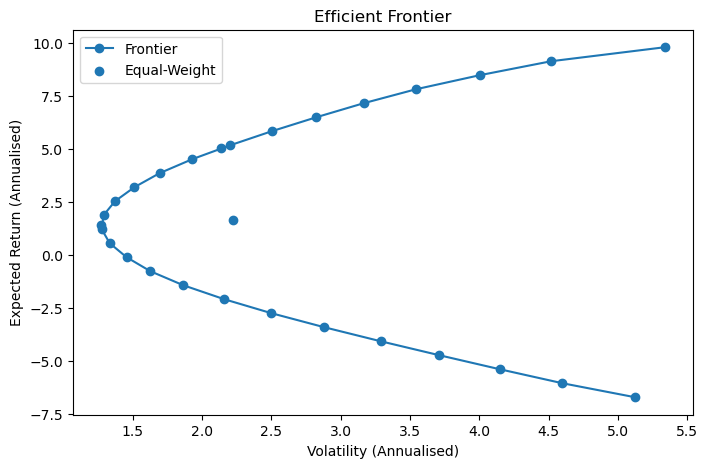

In [9]:

# Efficient frontier (one plot, no custom colors)
plt.figure()
plt.plot(ef_vols_ann, ef_returns_ann, marker='o', linestyle='-')
plt.xlabel("Volatility (Annualised)")
plt.ylabel("Expected Return (Annualised)")
plt.title("Efficient Frontier")
plt.scatter([vol_eq_ann, vol_mv_ann, vol_ms_ann],
            [mu_eq_ann,  mu_mv_ann,  mu_ms_ann])
plt.legend(["Frontier","Equal-Weight","Min-Var","Max-Sharpe"])
plt.show()


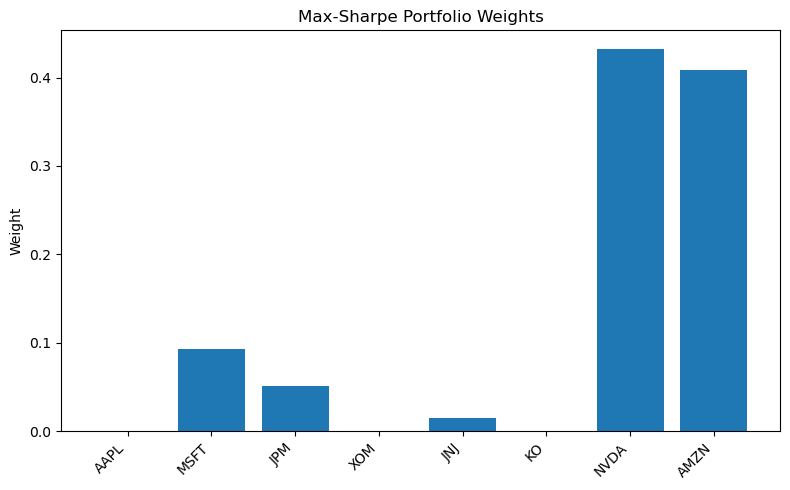

In [10]:

# Max-Sharpe weights
plt.figure()
plt.bar(tickers, w_maxsharpe)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Weight")
plt.title("Max-Sharpe Portfolio Weights")
plt.tight_layout()
plt.show()


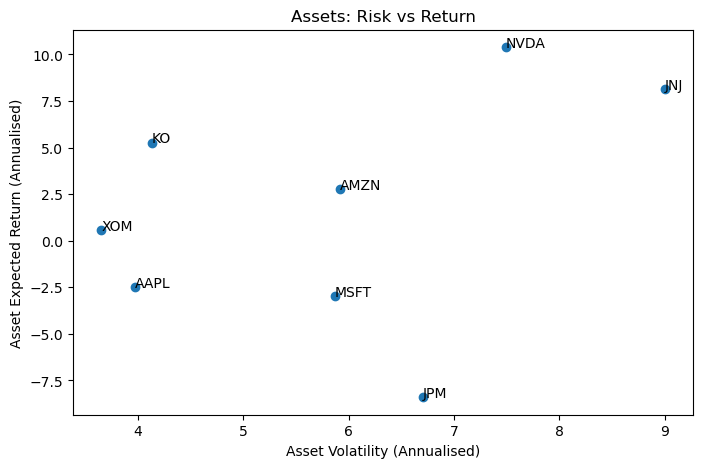

In [11]:

# Asset risk-return scatter
asset_returns_ann = annualize_return(R.mean().values, periods_per_year)
asset_vols_ann = annualize_vol(np.sqrt(np.diag(R.cov().values)), periods_per_year)
plt.figure()
plt.scatter(asset_vols_ann, asset_returns_ann)
for i, t in enumerate(tickers):
    plt.annotate(t, (asset_vols_ann[i], asset_returns_ann[i]))
plt.xlabel("Asset Volatility (Annualised)")
plt.ylabel("Asset Expected Return (Annualised)")
plt.title("Assets: Risk vs Return")
plt.show()


## 7) Save Outputs (Excel & CSV Template)

In [3]:

# Save weights/metrics to Excel; and write a CSV template with synthetic data you can overwrite
with pd.ExcelWriter("portfolio_example_outputs.xlsx", engine="xlsxwriter") as writer:
    weights_table.to_excel(writer, sheet_name="Weights", index=False)
    metrics_table.to_excel(writer, sheet_name="Metrics", index=False)

template = prices_df.copy()
template.insert(0, "Date", template.index.strftime("%Y-%m-%d"))
template["Benchmark"] = pd.Series(benchmark_prices, index=template.index).values
template.to_csv("template_prices.csv", index=False)

print("Saved files: portfolio_example_outputs.xlsx, template_prices.csv")


NameError: name 'weights_table' is not defined


## Notes & Extensions
- You can add **constraints** (e.g., sector caps, single-name caps) by modifying the optimizer bounds/constraints.
- For **shorting**, allow negative weights (e.g., bounds = (-0.3, 1.0)).
- Consider adding **turnover** and **transaction costs** if you evaluate rebalancing.
- For robustness, explore **resampled mean-variance**, **Black–Litterman**, or **shrunk covariance** (Ledoit–Wolf).
